##### 0. importing libraries that will be used

In [50]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

## 1. Data splitting
##### 1.1 Splitting data into train, validation and test sets
Using scikit-learn, develop a set of functions for data splitting using two
scenarios:

In [51]:
def split_data_TT(x, y):
    """ Split data into train (70%) and test (30%) sets."""
    return train_test_split(x, y, test_size=0.3, train_size=0.7)


def split_data_TVT(x, y, split_by_groups=None):
    """ Split data into train (40%), validation (30%) and test (30%) sets.
    If split_by_groups is not None, then the data is split in a way that
    each group is represented in only one set of the partition (We do this
    to avoid having the same group in both train, validation test sets).
    """
    if split_by_groups is None:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6, train_size=0.4, stratify=y)
        x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5,
                                                        train_size=0.5, stratify=y_test)
        return x_train, x_val, x_test, y_train, y_val, y_test
    else:
        # get the unique values of the groups and permute them randomly
        unique_group_values = split_by_groups.unique()
        unique_group_values = np.random.permutation(unique_group_values)

        # split the groups into train, validation and test sets and then take
        # the corresponding data
        train_idx = unique_group_values[:int(0.4 * len(unique_group_values))]
        val_idx = unique_group_values[int(0.4 * len(unique_group_values)):int(0.7 * len(unique_group_values))]
        test_idx = unique_group_values[int(0.7 * len(unique_group_values)):]

        # get the data corresponding to the groups
        x_train = x[split_by_groups.isin(train_idx)]
        x_val = x[split_by_groups.isin(val_idx)]
        x_test = x[split_by_groups.isin(test_idx)]

        y_train = y[split_by_groups.isin(train_idx)]
        y_val = y[split_by_groups.isin(val_idx)]
        y_test = y[split_by_groups.isin(test_idx)]

    return x_train, x_val, x_test, y_train, y_val, y_test


def split_data_CV(X, y, n_splits=10, n_repeats=10, groups=None):
    """ Split data into 10 splits, using one split as a test set.
    70% of the remaining 9 splits is for training and 30% for validation.
    Repeat this 10 times to obtain 100 splits in total. If groups is not None,
    then the data is split in a way that each group is represented in only one
    set of the partition """
    if groups is None:
        rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
        rskf.get_n_splits(X, y, groups=groups)

        folds = []
        for train_index, test_index in rskf.split(X, y):
            train_idx = np.random.choice(train_index, int(0.7 * len(train_index)), replace=False)
            val_idx = np.array([i for i in train_index if i not in train_idx])
            folds.append({
                'train_X': X[train_idx],
                'train_y': y[train_idx],
                'val_X': X[val_idx],
                'val_y': y[val_idx],
                'test_X': X[test_index],
                'test_y': y[test_index]
            })
        return folds
    else:
        l = groups.unique()
        folds = []
        for repeat in range(n_repeats):
            l = np.random.permutation(l)
            splits = np.array_split(l, n_splits)
            for i, split in enumerate(splits):
                train_val_group = np.concatenate(splits[:i] + splits[i + 1:])
                train_group = train_val_group[:int(0.7 * len(train_val_group))]
                val_group = train_val_group[int(0.7 * len(train_val_group)):]
                test_group = split
                train_idx = groups.isin(train_group)
                val_idx = groups.isin(val_group)
                test_idx = groups.isin(test_group)
                folds.append({
                    'train_X': X[train_idx],
                    'train_y': y[train_idx],
                    'val_X': X[val_idx],
                    'val_y': y[val_idx],
                    'test_X': X[test_idx],
                    'test_y': y[test_idx]
                })
        return folds

##### 1.2 Accuracy metrics
Using scikit-learn, develop a set of functions for calculating accuracy metrics, including the following
(https://scikit-learn.org/stable/modules/model_evaluation.html):
- 1.2.1. Confusion matrix
- 1.2.2. Recall
- 1.2.3. Precision
- 1.2.4. F1-score


In [52]:
def calculate_accuracy_metrics(y_true, y_pred, print_results=True, write_to_dict=None):
    """ Calculate accuracy metrics (confusion matrix, precision, recall, f1)
    and print them (if print_results is True). If write_to_dict is not None,
    then the metrics are also written to the dictionary. """
    cm = confusion_matrix(y_true, y_pred, normalize='all', labels=np.unique(y_true))
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    if print_results:
        print("Confusion matrix:\n")
        for row in cm:
            print('  '.join('{:.3f}'.format(x) for x in row))
        print(f"Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}\n")
    if write_to_dict is not None:
        write_to_dict['prec'].append(prec)
        write_to_dict['rec'].append(rec)
        write_to_dict['f1'].append(f1)
        write_to_dict['cm'].append(cm)

    return cm, prec, rec, f1


## 2. Initial experiments on Iris dataset
Initial experiments with a simple classifier, i.e. k-Nearest Neighbors (kNN)

In [53]:
# load the iris dataset
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
print(X_iris.shape, y_iris.shape)

(150, 4) (150,)


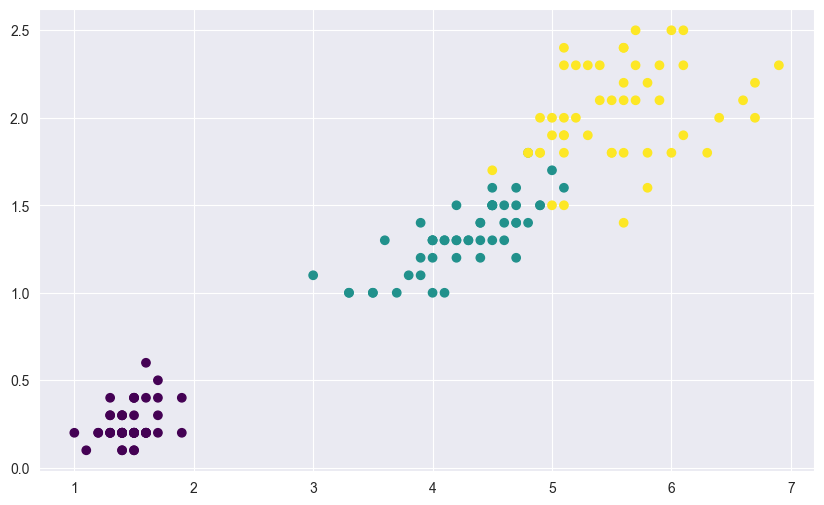

In [54]:
# scatter plot of the data
plt.figure(figsize=(10, 6))
plt.scatter(X_iris[:, 2], X_iris[:, 3], c=y_iris, cmap='viridis')

##### just a helper function, that we will use later to make printing the results easier

In [55]:
def print_results(metrics_dict):
    """ Print the results of the metrics dictionary in a nice format."""
    print("Average metrics:")
    print("          | mean | std")
    print(f"Precision | {np.mean(metrics_dict['prec']):.2f} | "
          f"{np.std(metrics_dict['prec']):.2f}")
    print(f"Recall    | {np.mean(metrics_dict['rec']):.2f} | "
            f"{np.std(metrics_dict['rec']):.2f}")
    print(f"F1        | {np.mean(metrics_dict['f1']):.2f} | "
            f"{np.std(metrics_dict['f1']):.2f}")

    # stack confusion matrices
    cm = np.stack(metrics_dict['cm'], axis=2)
    mean = np.round(np.mean(cm, axis=2), 3)
    std = np.round(np.std(cm, axis=2), 3)
    print("Normalized confusion matrix mean +- std:")
    # write the mean and std as a matrix with mean +- std
    for i in range(mean.shape[0]):
        for j in range(mean.shape[1]):
            print(f"{mean[i, j]:.3f} +- {std[i, j]:.3f} | ", end='')
        print()

##### 2.1.1 and 2.1.2
We do both exercise together, doing tirst "train only" for both, then "TVT" for both and finally "CV" for both.


#### Train only

In [56]:
def train_only(X, y, k_values):
    """ Train the kNN classifier on all data and print the results. """
    print("TRAIN ONLY")
    accuracy_metrics_dict  = {'prec': [], 'rec': [], 'f1': [], 'cm': []}
    print(f"Trying different k values: {k_values} on all data")
    print(" k | precision")
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        # train it on all data
        model = knn.fit(X, y)
        y_pred = model.predict(X)
        _, precision, _, _ = calculate_accuracy_metrics(y, y_pred, print_results=False, write_to_dict=accuracy_metrics_dict)
        print(f"{k:2} | {precision:.3f}")
    return accuracy_metrics_dict

In [57]:
# k = 1
_ = train_only(X_iris, y_iris, [1])

TRAIN ONLY
Trying different k values: [1] on all data
 k | precision
 1 | 1.000


In [58]:
# k in range {1, 3, ..., 15}
_ = train_only(X_iris, y_iris, list(range(1, 16, 2)))

TRAIN ONLY
Trying different k values: [1, 3, 5, 7, 9, 11, 13, 15] on all data
 k | precision
 1 | 1.000
 3 | 0.960
 5 | 0.967
 7 | 0.974
 9 | 0.980
11 | 0.973
13 | 0.980
15 | 0.987


This is a helper function that fids the best k value for a given dataset and prints the results.

In [59]:
def pick_best_k(x_train, x_val, y_train, y_val, k_values, show=True):
    """ function that picks the best k value based on validation set """
    best_f1 = -1
    best_k = None
    k_scores = []

    for i_k, k in enumerate(k_values):
        # fit the model on training set
        knn = KNeighborsClassifier(n_neighbors=k)
        model = knn.fit(x_train, y_train)

        # predict on validation set and calculate precision
        y_val_pred = model.predict(x_val)
        _, _, _, f1 = calculate_accuracy_metrics(y_val, y_val_pred, print_results=False)
        k_scores.append(f1)

        # save the k value if it's the best so far
        if f1 > best_f1:
            best_f1 = f1
            best_k = k

    # show results and return best k
    if show:
        print(f"best k chosen on validation set: {best_k} (f1: {best_f1:.3f})")
    return best_k, k_scores

#### Train-validation-test
in case where k=[1] it is equal as Train-Test split

In [60]:
def train_validation_test(X, y, k_values):
    """ Find the best k on the validation data and train the model with that k as a parameter. """
    print("TRAIN-VALIDATION-TEST")

    accuracy_metrics_dict = {'prec': [], 'rec': [], 'f1': [], 'cm': []}
    x_train, x_val, x_test, y_train, y_val, y_test = split_data_TVT(X, y)

    best_k, _ = pick_best_k(x_train, x_val, y_train, y_val, k_values)

    knn = KNeighborsClassifier(n_neighbors=best_k)

    # now train the best model on both train and validation data
    x_train = np.vstack((x_train, x_val))
    y_train = np.hstack((y_train, y_val))
    model = knn.fit(x_train, y_train)

    print("\nprecision on test set, using k chosen on validation set")
    y_test_pred = model.predict(x_test)
    calculate_accuracy_metrics(y_test, y_test_pred, write_to_dict=accuracy_metrics_dict)
    return accuracy_metrics_dict

In [61]:
_ = train_validation_test(X_iris, y_iris, [1])

TRAIN-VALIDATION-TEST
best k chosen on validation set: 1 (f1: 0.889)

precision on test set, using k chosen on validation set
Confusion matrix:

0.333  0.000  0.000
0.000  0.333  0.000
0.000  0.000  0.333
Precision: 1.00, Recall: 1.00, F1: 1.00



In [62]:
_ = train_validation_test(X_iris, y_iris, range(1, 16, 2))

TRAIN-VALIDATION-TEST
best k chosen on validation set: 5 (f1: 0.933)

precision on test set, using k chosen on validation set
Confusion matrix:

0.333  0.000  0.000
0.000  0.311  0.022
0.000  0.000  0.333
Precision: 0.98, Recall: 0.98, F1: 0.98



#### 10-fold cross-validation

In [63]:
def cross_validation_10x10(X, y, k_values, show=False):
    """ 10-fold cross validation. """
    print("10-FOLD CROSS VALIDATION")
    accuracy_metrics_dict = {'prec': [], 'rec': [], 'f1': [], 'cm': []}

    folds = split_data_CV(X, y)
    for i, fold in enumerate(folds):
        x_train, y_train = fold['train_X'], fold['train_y']
        x_val, y_val = fold['val_X'], fold['val_y']
        x_test, y_test = fold['test_X'], fold['test_y']

        if show:
            print(f"Fold {i+1}:", end=" ")
        best_k, _ = pick_best_k(x_train, x_val, y_train, y_val, k_values, show=show)

        knn = KNeighborsClassifier(n_neighbors=best_k)
        model = knn.fit(np.vstack((x_train, x_val)), np.hstack((y_train, y_val)))

        y_pred = model.predict(x_test)

        calculate_accuracy_metrics(y_test, y_pred, print_results=False, write_to_dict=accuracy_metrics_dict)

    return accuracy_metrics_dict

In [64]:
am = cross_validation_10x10(X_iris, y_iris, [1])
print_results(am)

10-FOLD CROSS VALIDATION
Average metrics:
          | mean | std
Precision | 0.97 | 0.04
Recall    | 0.96 | 0.05
F1        | 0.96 | 0.05
Normalized confusion matrix mean +- std:
0.333 +- 0.000 | 0.000 +- 0.000 | 0.000 +- 0.000 | 
0.000 +- 0.000 | 0.313 +- 0.033 | 0.020 +- 0.033 | 
0.000 +- 0.000 | 0.021 +- 0.035 | 0.313 +- 0.035 | 


In [65]:
am = cross_validation_10x10(X_iris, y_iris, range(1, 16, 2))
print_results(am)

10-FOLD CROSS VALIDATION
Average metrics:
          | mean | std
Precision | 0.97 | 0.04
Recall    | 0.96 | 0.04
F1        | 0.96 | 0.05
Normalized confusion matrix mean +- std:
0.333 +- 0.000 | 0.000 +- 0.000 | 0.000 +- 0.000 | 
0.000 +- 0.000 | 0.312 +- 0.031 | 0.021 +- 0.031 | 
0.000 +- 0.000 | 0.015 +- 0.031 | 0.318 +- 0.031 | 


## 2.1.3 Analyse the results
Training and testing on all data gives the best results, but the model is not very valuable as it is overfitted to the training data, so we don't have any guarantee that it will perform well on new unseen data.
Testing the model with TVT split is better as we test it on new data, but the results can still be biased, as we can be lucky by having easy examples in the test set.
The best way to test the model is to use 10x10 cross-validation, as it is the least biased way to test the model.

## 2.2 repeat with reliefF and Fisher score

##### first we implement refliefF and Fisher score

In [66]:
def ReliefF(X, y):
    """ Calculate the ReliefF score for each feature
    X: numpy array of shape (num_instances, num_features)
    y: numpy array of shape (num_instances, )
    """
    # copy the data
    X = np.copy(X)
    # scale each feature to [0,1] range
    X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    num_instances, num_feat = X.shape

    dist = np.zeros((num_instances, num_instances))

    for i in range(num_instances):
        dist[i, :] = np.linalg.norm(X - X[i, :], axis=1)

    # calculate the nearest hit and nearest miss for each sample
    weights = np.zeros((num_feat,))
    for idx in range(num_instances):
        label = y[idx]

        # find the nearest hit and nearest miss
        hit_distances = dist[idx, :].copy()
        hit_distances[y != label] = np.inf
        hit_distances[idx] = np.inf
        miss_distances = dist[idx, :].copy()
        miss_distances[y == label] = np.inf
        nearest_hit = np.argsort(hit_distances)[:3]
        nearest_miss = np.argsort(miss_distances)[:3]

        # print("hit", idx, nearest_hit, nearest_miss)
        # print("nearest_miss", nearest_miss1, nearest_miss)

        # calculate the weight for each feature
        weights += (X[idx, :] - np.mean(X[nearest_miss, :], axis=0)) ** 2 - (X[idx, :] - np.mean(X[nearest_hit, :], axis=0)) ** 2


    return weights / num_instances

In [67]:
def fisher_score(X, y):
    """ Calculate the fisher score for each feature """
    features_df = pd.DataFrame(X)
    features_df["class"] = y

    feat = features_df.columns[:-1]

    mu = features_df.groupby("class").mean()
    mu_all = features_df[feat].mean()
    sigma_all = features_df[feat].std()
    N = features_df.groupby("class").count().iloc[:, 0]
    fisher_scores = []

    for f in feat:
        mu_f = mu[f]
        mu_all_f = mu_all[f]
        sigma_all_f = sigma_all[f]

        fisher_scores.append((N * (mu_f - mu_all_f) ** 2).sum() / max((sigma_all_f ** 2), 1e-14))

    return fisher_scores

##### calculate the relief and fisher scores

In [68]:
relief_scores = ReliefF(X_iris, y_iris)
f_scores = fisher_score(X_iris, y_iris)

In [69]:
relief_scores

array([0.00733425, 0.04709748, 0.04697926, 0.05944187])

##### again some helper functions

In [70]:
def get_list_of_features(scores):
    """ function that returns a list of lists of features sorted by their score """
    sorted_indices = np.argsort(scores)[::-1]
    return [sorted_indices[:i] for i in range(1, len(scores) + 1)]

# get the list of features sorted by their score for each method
relief_feat = get_list_of_features(relief_scores)
fisher_feat = get_list_of_features(f_scores)

##### function that picks best features based on validation set and plots the elbow curve

In [71]:
def pick_best_features(x_train, x_val, y_train, y_val, features, k=1, show=True, plot_elbow=False):
    """ function that picks the best k value based on validation set """
    """ function that picks the best k value based on validation set """
    best_f1 = -1
    best_features = None
    f1_scores = []

    for feat in features:
        x_train_reduced = x_train[:, feat]
        x_val_reduced = x_val[:, feat]

        # fit the model on training set
        knn = KNeighborsClassifier(n_neighbors=k)
        model = knn.fit(x_train_reduced, y_train)

        # predict on validation set and calculate precision
        y_val_pred = model.predict(x_val_reduced)
        _, precision, rec, f1 = calculate_accuracy_metrics(y_val, y_val_pred, print_results=False)
        f1_scores.append(f1)

        # save the k value if it's the best so far
        if f1 > best_f1:
            best_f1 = f1
            best_features = feat

    # show results and return best k
    if show:
        print(f"best features chosen on validation set: {best_features} (prec: {best_f1:.3f})")

    if plot_elbow:
        plt.plot(range(len(f1_scores)), f1_scores)
        plt.xticks(range(len(f1_scores)), features, rotation=90)
        plt.xlabel("Features")
        plt.ylabel("F1 score")
        plt.show()
    return best_features, f1_scores

## 2.2.2 - 2.2.4

In [72]:
def find_best_model_TVT(X, y, feat, groups=None):
    x_train, x_val, x_test, y_train, y_val, y_test = split_data_TVT(X, y, split_by_groups=groups)

    # find the best features
    best_features, _ = pick_best_features(x_train, x_val, y_train, y_val, feat, show=True, plot_elbow=True)

    x_train_reduced = x_train[:, best_features]
    x_val_reduced = x_val[:, best_features]
    x_test_reduced = x_test[:, best_features]

    # find the best k
    best_k, _ = pick_best_k(x_train_reduced, x_val_reduced, y_train, y_val,
                         k_values=list(range(1, 16, 2)), show=False)

    # train again on the train and validation set
    knn = KNeighborsClassifier(n_neighbors=best_k)
    model = knn.fit(np.vstack((x_train_reduced, x_val_reduced)), np.hstack((y_train, y_val)))
    y_pred = model.predict(x_test_reduced)

    print("Results on test set:")
    calculate_accuracy_metrics(y_pred, y_test)

finding best model TVT, feature selection: relief
best features chosen on validation set: [3 1 2] (prec: 0.933)


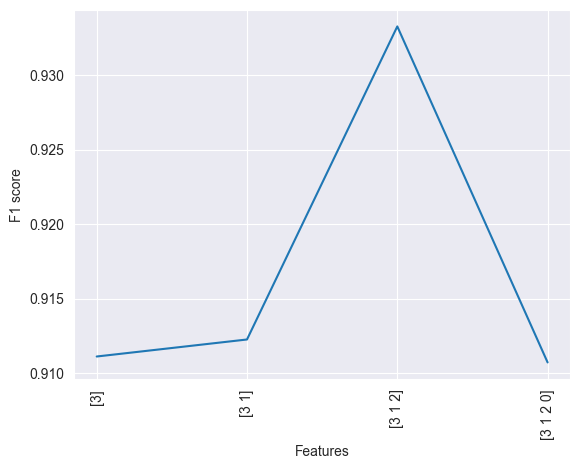

Results on test set:
Confusion matrix:

0.333  0.000  0.000
0.000  0.311  0.022
0.000  0.022  0.311
Precision: 0.96, Recall: 0.96, F1: 0.96

finding best model TVT, feature selection: fisher
best features chosen on validation set: [2] (prec: 0.933)


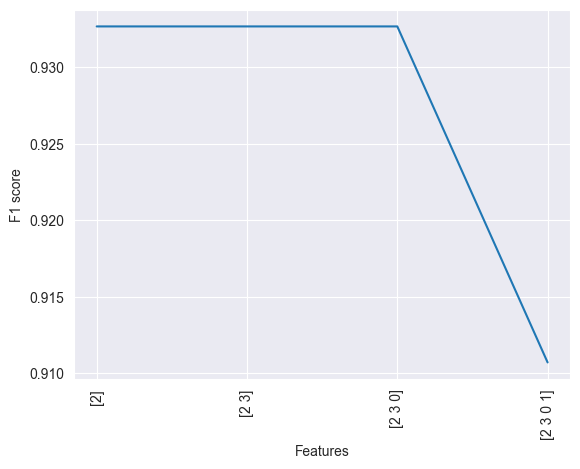

Results on test set:
Confusion matrix:

0.333  0.000  0.000
0.000  0.289  0.022
0.000  0.044  0.311
Precision: 0.93, Recall: 0.93, F1: 0.93

best features chosen on validation set: [2 3] (prec: 1.000)


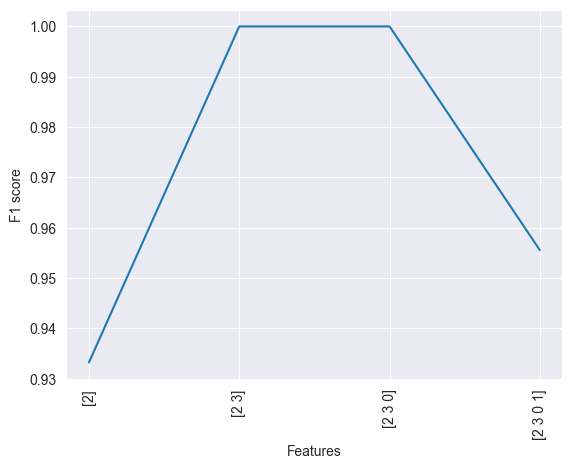

Results on test set:
Confusion matrix:

0.333  0.000  0.000
0.000  0.311  0.022
0.000  0.022  0.311
Precision: 0.96, Recall: 0.96, F1: 0.96



In [73]:
print("finding best model TVT, feature selection: relief")
find_best_model_TVT(X_iris, y_iris, relief_feat)
print("finding best model TVT, feature selection: fisher")
find_best_model_TVT(X_iris, y_iris, fisher_feat)
find_best_model_TVT(X_iris, y_iris, fisher_feat)

In [74]:
def print_mean_std(scores, a, b):
    """ print the mean and std of the scores """
    scores = np.array(scores)
    mean_scores = scores.mean(axis=0)
    std_scores = scores.std(axis=0)
    longest_a_len = max([len(str(x)) for x in a])
    print(f"          |   {b:11} |")
    print(f"          | mean  |  std  |")
    for i in range(len(a)):
        print(f"{str(a[i]):{longest_a_len}} | {mean_scores[i]:.3f} | {std_scores[i]:.3f} |")


def find_best_model_CV(X, y, feat, groups=None):
    # find the best features
    folds = split_data_CV(X, y, groups=groups)

    f1_scores = []
    for fold in folds:
        best_features, f1 = pick_best_features(fold["train_X"], fold["val_X"], fold["train_y"],
                                               fold["val_y"], feat, show=False, plot_elbow=False)
        f1_scores.append(f1)

    f1_scores = np.array(f1_scores)
    print_mean_std(f1_scores, feat, "k=1")

    feature_f1_scores = f1_scores.mean(axis=0)
    best_feature_idx = np.argmax(feature_f1_scores)
    best_features = feat[best_feature_idx]
    print("best features chosen on validation set: ", best_features)

    k_scores = []
    for fold in folds:
        x_train_reduced = fold["train_X"][:, best_features]
        x_test_reduced = fold["test_X"][:, best_features]

        # find the best k
        best_k, all_k = pick_best_k(x_train_reduced, x_test_reduced, fold["train_y"], fold["test_y"],
                                    k_values=list(range(1, 16, 2)), show=False)
        k_scores.append(all_k)

    k_scores = np.array(k_scores)
    print_mean_std(k_scores, list(range(1, 16, 2)), f"f={best_features}")

    k_f1_scores = k_scores.mean(axis=0)
    best_k_idx = np.argmax(k_f1_scores)
    best_k = list(range(1, 16, 2))[best_k_idx]
    print("best k chosen on validation set: ", best_k)

    # train again on the train and validation set with best features and best k
    knn = KNeighborsClassifier(n_neighbors=best_k)
    model = knn.fit(X[:, best_features], y)

    return model

In [75]:
print("finding best model 10x10 CV, feature selection: relief")
_ = find_best_model_CV(X_iris, y_iris, relief_feat)
print("finding best model 10x10 CV, feature selection: fisher")
_ = find_best_model_CV(X_iris, y_iris, fisher_feat)

finding best model 10x10 CV, feature selection: relief
          |   k=1         |
          | mean  |  std  |
[3]       | 0.921 | 0.052 |
[3 1]     | 0.923 | 0.036 |
[3 1 2]   | 0.955 | 0.028 |
[3 1 2 0] | 0.953 | 0.031 |
best features chosen on validation set:  [3 1 2]
          |   f=[3 1 2]   |
          | mean  |  std  |
1  | 0.953 | 0.055 |
3  | 0.957 | 0.052 |
5  | 0.962 | 0.048 |
7  | 0.961 | 0.053 |
9  | 0.966 | 0.051 |
11 | 0.965 | 0.050 |
13 | 0.963 | 0.049 |
15 | 0.959 | 0.050 |
best k chosen on validation set:  9
finding best model 10x10 CV, feature selection: fisher
          |   k=1         |
          | mean  |  std  |
[2]       | 0.916 | 0.035 |
[2 3]     | 0.954 | 0.030 |
[2 3 0]   | 0.953 | 0.027 |
[2 3 0 1] | 0.950 | 0.026 |
best features chosen on validation set:  [2 3]
          |   f=[2 3]     |
          | mean  |  std  |
1  | 0.952 | 0.051 |
3  | 0.953 | 0.048 |
5  | 0.959 | 0.048 |
7  | 0.961 | 0.044 |
9  | 0.961 | 0.044 |
11 | 0.961 | 0.047 |
13 | 0.965 | 0.0

# Draw conclusions in terms of the bias-variance and underfitting-overfitting dilemma.
K = 1 -> The model tends to have high variance, capturing noise in the data. (Overfitting)

K > 1 -> As you increase k, the model generalizes better and the variance decreases. However, if you increase k too much, it leads to underfitting and the model starts to oversimplify the underlying patterns.

## 2.4

In [76]:
# reduce the iris dataset to
y_iris_reduced = np.hstack((y_iris[:50], y_iris[50:80], y_iris[100:110]))
X_iris_reduced = np.vstack((X_iris[:50], X_iris[50:80], X_iris[100:110]))

In [77]:
relief_scores = ReliefF(X_iris_reduced, y_iris_reduced)
f_scores = fisher_score(X_iris_reduced, y_iris_reduced)

relief_feat = get_list_of_features(relief_scores)
fisher_feat = get_list_of_features(f_scores)

print("features selected by relief: ")
for f in relief_feat:
    print(f)

print("features selected by fisher: ")
for f in fisher_feat:
    print(f)


features selected by relief: 
[2]
[2 3]
[2 3 1]
[2 3 1 0]
features selected by fisher: 
[2]
[2 3]
[2 3 0]
[2 3 0 1]


finding best model TVT, feature selection: relief
best features chosen on validation set: [2 3 1] (prec: 1.000)


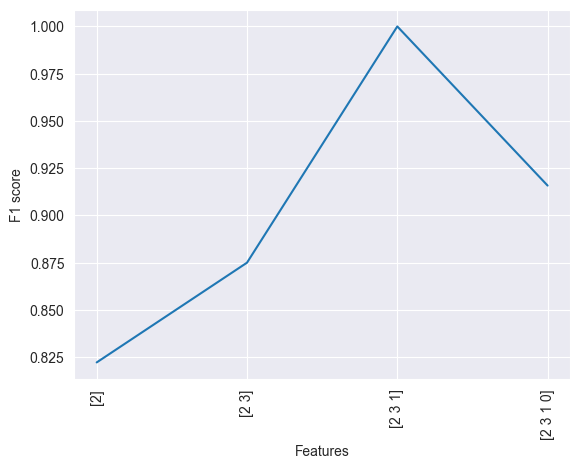

Results on test set:
Confusion matrix:

0.556  0.000  0.000
0.000  0.296  0.000
0.000  0.037  0.111
Precision: 0.96, Recall: 0.92, F1: 0.93

finding best model TVT, feature selection: fisher
best features chosen on validation set: [2] (prec: 1.000)


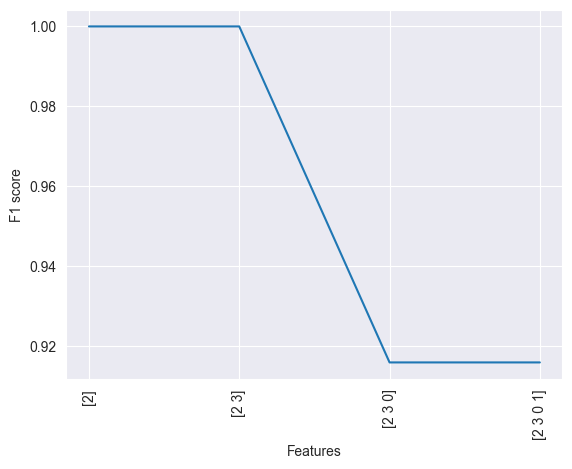

Results on test set:
Confusion matrix:

0.556  0.000  0.000
0.000  0.333  0.037
0.000  0.000  0.074
Precision: 0.89, Recall: 0.97, F1: 0.92



In [78]:
print("finding best model TVT, feature selection: relief")
find_best_model_TVT(X_iris_reduced, y_iris_reduced, relief_feat)
print("finding best model TVT, feature selection: fisher")
find_best_model_TVT(X_iris_reduced, y_iris_reduced, fisher_feat)

In [79]:
print("finding best model 10x10 CV, feature selection: relief")
_ = find_best_model_CV(X_iris, y_iris, relief_feat)
print("finding best model 10x10 CV, feature selection: fisher")
_ = find_best_model_CV(X_iris, y_iris, fisher_feat)


finding best model 10x10 CV, feature selection: relief
          |   k=1         |
          | mean  |  std  |
[2]       | 0.922 | 0.041 |
[2 3]     | 0.952 | 0.032 |
[2 3 1]   | 0.951 | 0.029 |
[2 3 1 0] | 0.952 | 0.029 |
best features chosen on validation set:  [2 3]
          |   f=[2 3]     |
          | mean  |  std  |
1  | 0.960 | 0.046 |
3  | 0.956 | 0.051 |
5  | 0.962 | 0.049 |
7  | 0.964 | 0.046 |
9  | 0.963 | 0.046 |
11 | 0.962 | 0.049 |
13 | 0.964 | 0.045 |
15 | 0.963 | 0.041 |
best k chosen on validation set:  7
finding best model 10x10 CV, feature selection: fisher
          |   k=1         |
          | mean  |  std  |
[2]       | 0.918 | 0.046 |
[2 3]     | 0.953 | 0.031 |
[2 3 0]   | 0.953 | 0.024 |
[2 3 0 1] | 0.953 | 0.025 |
best features chosen on validation set:  [2 3 0]
          |   f=[2 3 0]   |
          | mean  |  std  |
1  | 0.952 | 0.052 |
3  | 0.957 | 0.052 |
5  | 0.959 | 0.047 |
7  | 0.959 | 0.047 |
9  | 0.960 | 0.048 |
11 | 0.961 | 0.049 |
13 | 0.957 | 0.0

# Analyze the results in terms of the impact of class imbalance.
versicolor = 30 samples

virginica = 10 samples

From theory we know the imbalance will result in bias torwards majority class, which is versicolor.This is because the model will be trained on more versicolor samples, so it will be more likely to predict versicolor. Analysing the confusion matrixes results validates our assumptions.



## 3. Experiments on the dataset of facial expressions


In [80]:
emotion_data = pd.read_csv("top_10_relieff.csv")
emotion_data

,mean_distance_48_54,mean_distance_62_66,std_distance_48_54,std_distance_51_57,mean_distance_23_43,mean_distance_20_38,std_distance_62_66,triangle_area_51_57_54,mean_angles_23_25,mean_distance_15_35,emotion,actor
0,0.100664,0.007399,0.002523,0.011692,0.049992,0.046413,0.006194,0.001402,0.006467,0.124195,neutral,1
1,0.094378,0.017265,0.005688,0.006170,0.048530,0.045028,0.005654,0.001660,-0.045955,0.146302,fearful,1
2,0.094991,0.025533,0.002922,0.009377,0.054258,0.053013,0.006717,0.001800,0.026439,0.119625,fearful,1
3,0.103376,0.021364,0.004855,0.010208,0.043060,0.040022,0.010567,0.001796,-0.110721,0.145583,disgust,1
4,0.102074,0.024980,0.004694,0.009039,0.041511,0.039141,0.009713,0.001829,-0.143814,0.142900,disgust,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2447,0.096226,0.018297,0.005826,0.021249,0.078875,0.076400,0.014951,0.001745,0.033057,0.158270,neutral,24
2448,0.100180,0.017758,0.006915,0.020929,0.074344,0.071745,0.019611,0.001796,-0.065240,0.141604,neutral,24
2449,0.100390,0.009850,0.006617,0.009561,0.070083,0.067765,0.008958,0.001586,-0.054571,0.136799,calm,24
2450,0.098706,0.011474,0.003457,0.016221,0.073625,0.070760,0.012376,0.001622,-0.084250,0.142263,neutral,24


In [81]:
X_emotion = emotion_data.drop(columns=["emotion", "actor"]).values
y_emotion = emotion_data["emotion"].values
groups = emotion_data["actor"]

In [82]:
relief_scores = ReliefF(X_emotion, y_emotion)
relief_feat = get_list_of_features(relief_scores)

fisher_scores = fisher_score(X_emotion, y_emotion)
fisher_feat = get_list_of_features(fisher_scores)

finding best model TVT, feature selection: relief
best features chosen on validation set: [0 8 7 1 9 3 4 6 5 2] (prec: 0.235)


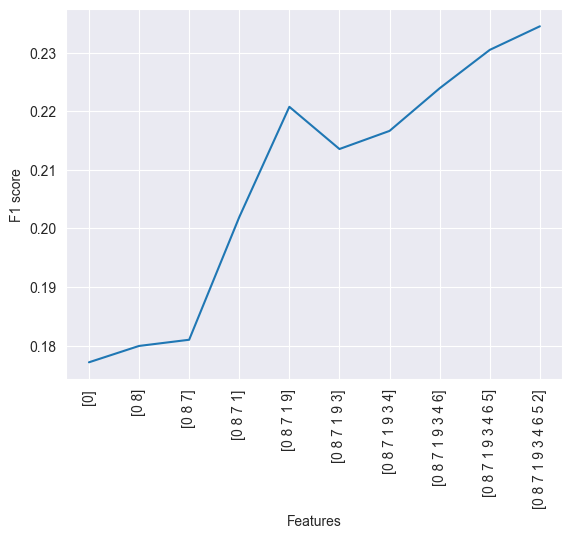

Results on test set:
Confusion matrix:

0.082  0.007  0.018  0.034  0.010  0.004  0.019  0.008
0.011  0.052  0.002  0.006  0.035  0.019  0.034  0.016
0.010  0.002  0.006  0.005  0.002  0.001  0.006  0.002
0.019  0.035  0.018  0.073  0.024  0.023  0.047  0.026
0.001  0.014  0.005  0.005  0.069  0.001  0.007  0.006
0.005  0.014  0.002  0.006  0.000  0.011  0.005  0.004
0.019  0.024  0.019  0.018  0.011  0.016  0.028  0.008
0.007  0.005  0.006  0.007  0.004  0.002  0.008  0.006
Precision: 0.28, Recall: 0.30, F1: 0.28



In [83]:
print("finding best model TVT, feature selection: relief")
find_best_model_TVT(X_emotion, y_emotion, relief_feat, groups=groups)

finding best model TVT, feature selection: fisher
best features chosen on validation set: [0 8 7 1] (prec: 0.249)


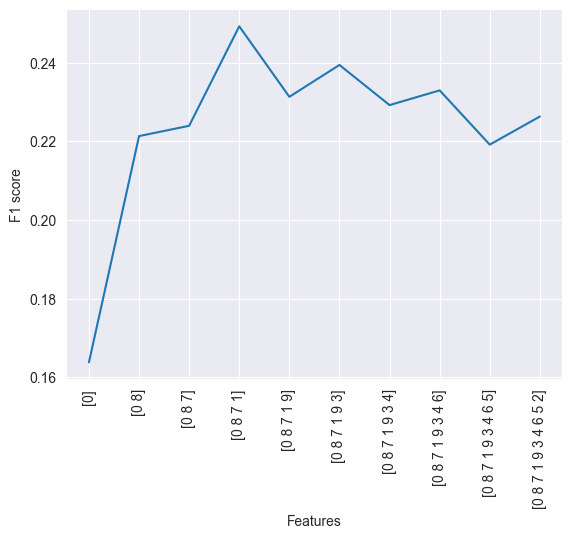

Results on test set:
Confusion matrix:

0.084  0.024  0.032  0.043  0.011  0.011  0.027  0.015
0.009  0.044  0.005  0.009  0.027  0.014  0.025  0.006
0.011  0.008  0.000  0.013  0.004  0.000  0.011  0.008
0.029  0.029  0.019  0.048  0.016  0.016  0.024  0.018
0.003  0.020  0.006  0.008  0.077  0.001  0.009  0.015
0.003  0.013  0.006  0.008  0.005  0.011  0.014  0.006
0.005  0.011  0.006  0.019  0.008  0.018  0.034  0.010
0.009  0.003  0.006  0.005  0.004  0.004  0.008  0.003
Precision: 0.26, Recall: 0.25, F1: 0.25



In [84]:
print("finding best model TVT, feature selection: fisher")
find_best_model_TVT(X_emotion, y_emotion, relief_feat, groups=groups)

In [85]:
find_best_model_CV(X_emotion, y_emotion, relief_feat, groups=groups)

          |   k=1         |
          | mean  |  std  |
[0]                   | 0.172 | 0.013 |
[0 8]                 | 0.207 | 0.015 |
[0 8 7]               | 0.209 | 0.015 |
[0 8 7 1]             | 0.251 | 0.018 |
[0 8 7 1 9]           | 0.248 | 0.019 |
[0 8 7 1 9 3]         | 0.270 | 0.022 |
[0 8 7 1 9 3 4]       | 0.276 | 0.020 |
[0 8 7 1 9 3 4 6]     | 0.283 | 0.020 |
[0 8 7 1 9 3 4 6 5]   | 0.279 | 0.020 |
[0 8 7 1 9 3 4 6 5 2] | 0.281 | 0.020 |
best features chosen on validation set:  [0 8 7 1 9 3 4 6]
          |   f=[0 8 7 1 9 3 4 6] |
          | mean  |  std  |
1  | 0.270 | 0.040 |
3  | 0.254 | 0.038 |
5  | 0.270 | 0.040 |
7  | 0.268 | 0.041 |
9  | 0.270 | 0.041 |
11 | 0.275 | 0.040 |
13 | 0.276 | 0.040 |
15 | 0.275 | 0.042 |
best k chosen on validation set:  13


KNeighborsClassifier(n_neighbors=13)

## 4. Experiments on the dataset of facial expressions with MLP

In [86]:
# best results are with all the features
selected_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
X_emotion_reduced = X_emotion[:, selected_features]

# split the data into train, validation and test set
X_emotions_train, X_emotions_val, X_emotions_test, y_emotions_train, y_emotions_val, y_emotions_test = split_data_TVT(X_emotion_reduced, y_emotion, split_by_groups=groups)


#### helper function to plot the confusion matrix

In [87]:
def plot_confusion_matrix(c_matrix, y_true):
    plt.matshow(c_matrix, cmap='Blues')
    # annotate the confusion matrix
    for i in range(c_matrix.shape[0]):
        for j in range(c_matrix.shape[1]):
            if c_matrix[i, j] > 0:
                plt.text(x=j, y=i, s=round(c_matrix[i, j], 3), va='center', ha='center', size='small')
    # add the class names to the axes
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    labels = np.unique(y_true)
    plt.xticks(range(len(labels)), labels)
    plt.yticks(range(len(labels)), labels)

    plt.show()

#### just try if it works

In [88]:
clf = MLPClassifier(random_state=1, max_iter=10000, hidden_layer_sizes=(200,),
                    activation='logistic').fit(X_emotions_train, y_emotions_train)

print(clf.predict_proba(X_emotions_test[:1]), y_emotions_test[:1])
print(clf.predict(X_emotions_test[:5, :]), y_emotions_test[:5])

y_test_pred = clf.predict(X_emotions_test)
cm, pr, rec, f1 = calculate_accuracy_metrics(y_emotions_test, y_test_pred)


[[8.35791621e-01 1.28543524e-03 1.09350176e-01 3.24355550e-02
  1.10599449e-02 5.82496431e-04 1.54252504e-03 7.95224621e-03]] ['angry']
['angry' 'angry' 'sad' 'angry' 'angry'] ['angry' 'angry' 'calm' 'angry' 'angry']
Confusion matrix:

0.099  0.008  0.000  0.025  0.002  0.000  0.019  0.000
0.000  0.072  0.000  0.023  0.024  0.000  0.035  0.000
0.030  0.002  0.000  0.013  0.005  0.000  0.026  0.000
0.022  0.018  0.000  0.046  0.012  0.000  0.056  0.000
0.007  0.017  0.000  0.022  0.106  0.000  0.002  0.000
0.000  0.018  0.000  0.007  0.000  0.000  0.052  0.000
0.005  0.028  0.000  0.031  0.004  0.000  0.087  0.000
0.005  0.004  0.000  0.013  0.010  0.000  0.046  0.000
Precision: 0.27, Recall: 0.33, F1: 0.30



#### function that fins best model using TVT split among all the combinations of parameters

In [89]:
def find_best_mlp_model_TVT(X, y, groups=None, param_combinations=None):
    x_train, x_val, x_test, y_train, y_val, y_test = split_data_TVT(X, y, split_by_groups=groups)

    f1_scores = []

    for param in param_combinations:
        print([f"{k[:8]}: {v}" for k, v in param.items()], end=" ")
        clf = MLPClassifier(random_state=1, max_iter=10000, batch_size=100,
                            solver=param["solver"],
                            hidden_layer_sizes=(param["hidden_layer_sizes"],),
                            learning_rate=param["learning_rate"],
                            momentum=param["momentum"],
                            activation='logistic').fit(x_train, y_train)

        y_pred = clf.predict(x_val)
        cm, pr, rec, f1 = calculate_accuracy_metrics(y_val, y_pred, print_results=False)
        f1_scores.append(f1)
        print("-> f1:", round(f1, 3), "prec", round(pr, 3), "rec", round(rec, 3))

    best_param = param_combinations[np.argmax(f1_scores)]
    print("Best param: ", best_param)

    clf = MLPClassifier(random_state=1, max_iter=10000, batch_size=100,
                        solver=best_param["solver"],
                        hidden_layer_sizes=(best_param["hidden_layer_sizes"],),
                        learning_rate=best_param["learning_rate"],
                        momentum=best_param["momentum"],
                        activation='logistic').fit(np.vstack((x_train, x_val)),
                                                   np.hstack((y_train, y_val)))

    y_pred = clf.predict(x_test)

    cm, pr, rec, f1 = calculate_accuracy_metrics(y_test, y_pred, print_results=False)

    plot_confusion_matrix(cm, y_test)
    print("Results on test set:")
    print("Precision: ", pr)
    print("Recall: ", rec)
    print("F1: ", f1)


#### Try different combinations of parameters (hidden layer size, learning rate, momentum, solver)

In [90]:
hidden_layer_sizes = [10, 50, 100, 250, 500]
learning_rates = ['constant', 'invscaling', 'adaptive']
momentums = [0, 0.5, 0.9]
solvers = ['sgd', 'adam']

param_combinations = []
for s in solvers:
    for h in hidden_layer_sizes:
        if s == 'sgd':
            for l in learning_rates:
                for m in momentums:
                    param_combinations.append({"hidden_layer_sizes": h,
                                               "learning_rate": l,
                                               "momentum": m,
                                               "solver": s})
        else:
            param_combinations.append({"hidden_layer_sizes": h,
                                       "learning_rate": 'constant',
                                       "momentum": 0,
                                       "solver": s})

print("number of param combinations: ", len(param_combinations))

number of param combinations:  50


['hidden_l: 10', 'learning: constant', 'momentum: 0', 'solver: sgd'] -> f1: 0.033 prec 0.019 rec 0.125
['hidden_l: 10', 'learning: constant', 'momentum: 0.5', 'solver: sgd'] -> f1: 0.049 prec 0.11 rec 0.131
['hidden_l: 10', 'learning: constant', 'momentum: 0.9', 'solver: sgd'] -> f1: 0.069 prec 0.079 rec 0.122
['hidden_l: 10', 'learning: invscaling', 'momentum: 0', 'solver: sgd'] -> f1: 0.018 prec 0.01 rec 0.125
['hidden_l: 10', 'learning: invscaling', 'momentum: 0.5', 'solver: sgd'] -> f1: 0.018 prec 0.01 rec 0.125
['hidden_l: 10', 'learning: invscaling', 'momentum: 0.9', 'solver: sgd'] -> f1: 0.018 prec 0.01 rec 0.125
['hidden_l: 10', 'learning: adaptive', 'momentum: 0', 'solver: sgd'] -> f1: 0.033 prec 0.019 rec 0.125
['hidden_l: 10', 'learning: adaptive', 'momentum: 0.5', 'solver: sgd'] -> f1: 0.049 prec 0.102 rec 0.131
['hidden_l: 10', 'learning: adaptive', 'momentum: 0.9', 'solver: sgd'] -> f1: 0.112 prec 0.106 rec 0.142
['hidden_l: 50', 'learning: constant', 'momentum: 0', 'solv

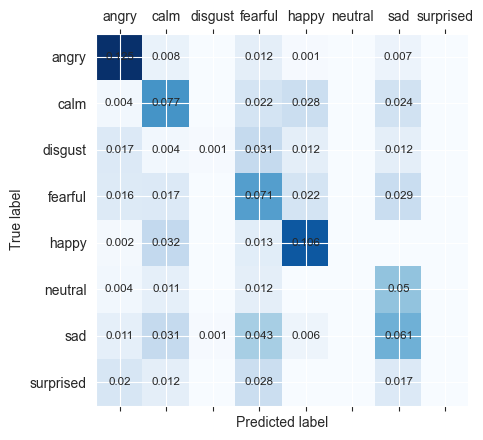

Results on test set:
Precision:  0.3435360356811674
Recall:  0.359375
F1:  0.3178372110409934


In [91]:
import warnings
warnings.filterwarnings('ignore')

find_best_mlp_model_TVT(X_emotion_reduced, y_emotion, groups=groups,
                        param_combinations=param_combinations)

#### 4.4 discuss the results
For some reason the sgd solver produces really bad results, while the adam solver produces okay results (f score ~ 0.3).
We should probably go back to the feature selection step and try to find better features.

# 5. Our implementation of MLP with backpropagation

In [92]:
def sigmoid(x):
    # sigmoid function
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x):
    # derivative of sigmoid function
    return (sigmoid(x) * (1 - sigmoid(x))).flatten()


def relu(x):
    # relu function
    return np.maximum(0, x)


def relu_derivative(x):
    # derivative of relu function
    return (x > 0).astype(int)


class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, lr=0.1):
        self.v = np.random.randn(input_size, hidden_size)
        self.w = np.random.randn(hidden_size, output_size)

        self.b = np.zeros(hidden_size)
        self.b2 = np.zeros(output_size)

        self.lr = lr

        self.log = {"f1_val": [], "f1_train": []}

    def __str__(self):
        s = "my neural network\n"
        s += f"v: {self.v.shape}\n"
        s += f"w: {self.w.shape}\n"
        s += f"b: {self.b.shape}\n"
        s += f"b2: {self.b2.shape}\n\n"
        return s

    def feedforward(self, x):
        """ feedforward the input through the network """
        y = np.dot(x, self.v) + self.b
        y_hat = relu(y)

        z = np.dot(y_hat, self.w) + self.b2
        z_hat = sigmoid(z)

        return y, y_hat, z, z_hat

    def backprop(self, x, true_values, y, y_hat, z, z_hat):
        """ backpropagation of the error and updates the weights """

        # print("x", x.shape)
        # print("z_hat", z_hat.shape)

        dl_dz_hat = 2 * (z_hat - true_values)
        # print("dl_dz_hat", dl_dz_hat.shape)
        dz_hat_dz = sigmoid_derivative(z)
        # print("dz_hat_dz", dz_hat_dz.shape)

        dz_dy_hat = self.w
        # print("dz_dy_hat", dz_dy_hat.shape)
        dz_db2 = np.ones(self.b2.shape)
        # print("dz_db2", dz_db2.shape)
        dz_dw = np.repeat(y_hat, self.w.shape[1], axis=0).reshape(self.w.shape)
        # print("dz_dw", dz_dw.shape)

        dy_hat_dy = relu_derivative(y)
        # print("dy_hat_dy", dy_hat_dy.shape)
        dy_db = np.ones(self.b.shape)
        # print("dy_db", dy_db.shape)
        dy_dv = np.repeat(x, self.v.shape[1], axis=0).reshape(self.v.shape)
        # print("dy_dv", dy_dv.shape)

        dl_dz = dl_dz_hat * dz_hat_dz
        # print("dl_dz", dl_dz.shape)
        dl_dy = np.dot(dz_dy_hat, dl_dz) * dy_hat_dy
        # print("dl_dy", dl_dy.shape)

        dl_db2 = dl_dz * dz_db2
        # print("dl_db2", dl_db2.shape)
        dl_dw = dl_dz * dz_dw
        # print("dl_dw", dl_dw.shape)

        dl_db = dl_dy * dy_db
        # print("dl_db", dl_db.shape)
        dl_dv = dl_dy * dy_dv
        # print("dl_dv", dl_dv.shape)

        # print("b2", self.b2.shape, dl_db2.shape)
        self.b2 = self.b2 - self.lr * dl_db2

        # print("w", self.w.shape, dl_dw.shape)
        self.w = self.w - self.lr * dl_dw

        # print("b", self.b.shape, dl_db.flatten().shape)
        self.b = self.b - self.lr * dl_db

        # print("v", self.v.shape, dl_dv.shape)
        self.v = self.v - self.lr * dl_dv

    def train_one_epoch(self, all_x, all_y):
        for i, (xx, yy) in enumerate(zip(all_x, all_y)):
            y, y_hat, z, z_hat = self.feedforward(xx)
            self.backprop(xx, yy, y, y_hat, z, z_hat)

    def train(self, x, y, x_val, y_val, epochs=10):
        """ train the network """
        for i in range(epochs):
            self.train_one_epoch(x, y)
            if i % 10 == 0:
                self.log_progress(x, y, x_val, y_val)

    def predict(self, x):
        """ predict the output for the given input """
        _, _, _, z_hat = self.feedforward(x)
        return z_hat

    def log_progress(self, x, y, x_val, y_val):
        """ log the progress of the network """
        y_hat = self.predict(x)
        y_hat_val = self.predict(x_val)

        # one hot encoding back to normal
        y = np.argmax(y, axis=1)
        y_hat = np.argmax(y_hat, axis=1)
        y_val = np.argmax(y_val, axis=1)
        y_hat_val = np.argmax(y_hat_val, axis=1)

        loss = np.sum(np.power(y - y_hat, 2))

        _, _, _, f1_train = calculate_accuracy_metrics(y, y_hat, print_results=False)
        _, _, _, f1_val = calculate_accuracy_metrics(y_val, y_hat_val, print_results=False)
        self.log["f1_train"].append(f1_train)
        self.log["f1_val"].append(f1_val)

        print(f"epoch: {len(self.log['f1_train']) * 10}, f1_train: {f1_train}, "
              f"f1_val: {f1_val}, loss: {loss}")



In [93]:
X_emotions_train.shape

(936, 10)

#### Create a neural network with 1 hidden layer, 50 neurons, learning rate 0.001 and 8 output neurons (one for each emotion) and train it on the emotions dataset

In [99]:
nn = NeuralNetwork(len(selected_features), 50, 8, lr=0.001)

y_emotions_train_1_hot = np.zeros((len(y_emotions_train), 8))
y_emotions_test_1_hot = np.zeros((len(y_emotions_test), 8))
y_emotions_val_1_hot = np.zeros((len(y_emotions_val), 8))

for i, emotion in enumerate(np.unique(y_emotions_train)):
    y_emotions_train_1_hot[y_emotions_train == emotion, i] = 1
    y_emotions_test_1_hot[y_emotions_test == emotion, i] = 1
    y_emotions_val_1_hot[y_emotions_val == emotion, i] = 1

nn.train(X_emotions_train, y_emotions_train_1_hot, X_emotions_val, y_emotions_val_1_hot, epochs=1500)

epoch: 10, f1_train: 0.07111249148332717, f1_val: 0.05159774044635729, loss: 8510
epoch: 20, f1_train: 0.1106049578302699, f1_val: 0.11564068404619586, loss: 8404
epoch: 30, f1_train: 0.1347563835414579, f1_val: 0.12933833306659784, loss: 8308
epoch: 40, f1_train: 0.1333455339227835, f1_val: 0.13915835521678255, loss: 8192
epoch: 50, f1_train: 0.15490233312167184, f1_val: 0.1776237658874581, loss: 8217
epoch: 60, f1_train: 0.17139855692921846, f1_val: 0.1908566436774706, loss: 8129
epoch: 70, f1_train: 0.17829400049348554, f1_val: 0.19957421839638495, loss: 8018
epoch: 80, f1_train: 0.17468962355877604, f1_val: 0.20007891055449023, loss: 8084
epoch: 90, f1_train: 0.1765246324482864, f1_val: 0.2050884812282042, loss: 8048
epoch: 100, f1_train: 0.17655982484708355, f1_val: 0.2035095874663474, loss: 7997
epoch: 110, f1_train: 0.1779967604073154, f1_val: 0.20504630265273988, loss: 8024
epoch: 120, f1_train: 0.1813655250263321, f1_val: 0.20356279810039773, loss: 8006
epoch: 130, f1_train: 0

In [100]:
y_predict_test = nn.predict(X_emotions_test)
y_predict_test = np.argmax(y_predict_test, axis=1)

In [101]:
# back to original labels
y_predict_test = np.array([np.unique(y_emotions_train)[i] for i in y_predict_test])
for pred_v, true_v in zip(y_predict_test[:10], y_emotions_test[:10]):
    print(f"predicted: {pred_v:10}, true: {true_v:10}")


predicted: angry     , true: angry     
predicted: angry     , true: angry     
predicted: angry     , true: calm      
predicted: angry     , true: angry     
predicted: angry     , true: angry     
predicted: angry     , true: fearful   
predicted: angry     , true: fearful   
predicted: angry     , true: angry     
predicted: angry     , true: calm      
predicted: angry     , true: angry     


Confusion matrix:

0.105  0.002  0.000  0.024  0.008  0.000  0.014  0.000
0.019  0.049  0.000  0.005  0.058  0.000  0.023  0.000
0.035  0.000  0.000  0.005  0.008  0.000  0.029  0.000
0.034  0.000  0.000  0.036  0.022  0.000  0.062  0.000
0.004  0.016  0.000  0.006  0.120  0.000  0.008  0.000
0.011  0.005  0.000  0.005  0.012  0.000  0.044  0.000
0.028  0.031  0.000  0.011  0.019  0.000  0.065  0.000
0.017  0.006  0.000  0.006  0.013  0.001  0.034  0.000
Precision: 0.24, Recall: 0.30, F1: 0.26



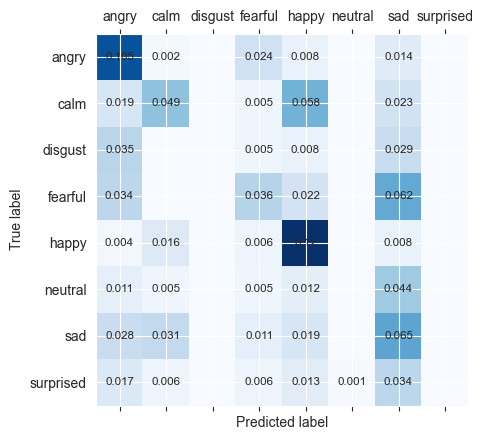

In [102]:
# get the accuracy metrics
cm, _, _, _ = calculate_accuracy_metrics(y_emotions_test, y_predict_test)
plot_confusion_matrix(cm, y_emotions_test)

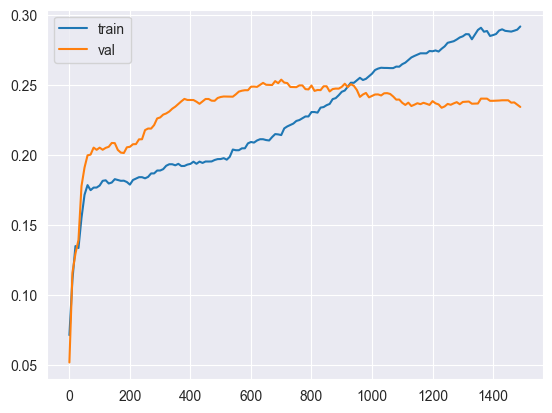

In [103]:
# plot the log:
x_train = nn.log["f1_train"]
x_val = nn.log["f1_val"]

y = np.arange(0, len(x_train) * 10, 10)
plt.plot(y, x_train, label="train")
plt.plot(y, x_val, label="val")
plt.legend()

Authors:

Nace Sever	uc2023158749@student.uc.pt

José Pedro Namora Pereira Dias	uc2023164985@student.uc.pt